# Movie remakes analysis

In [65]:
# import required libraries

import numpy as np
from ada_config.config import CONFIG

import random
import pandas as pd

from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
np.bool = np.bool_
from datawig import SimpleImputer

from regression_utils import regress, plot_significance_plotly_regression_all, check_each_col_treat, plot_ate_or_histograms

random.seed(42)
np.random.seed(42)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import openai
from scipy.stats import ttest_ind
from scipy.stats import linregress

from scipy.stats import kstest
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import t

import statsmodels.api as sm

import plotly.io as pio


import json
from ada_config.config import CONFIG

from scipy.stats import binomtest
from scipy.stats import ttest_1samp, wilcoxon
import plotly.graph_objects as go

from regression_utils import plot_significance_plotly_regression_all


## Loading data

In [49]:
# load movie metadata

# Load movie metadata
df_movies = pd.read_csv(CONFIG["data_path"] / "MovieVerse.csv")

# Load charachter metadata
df_chars  = pd.read_csv(CONFIG["cmu_path"] / "character_metadata.csv")

# load movie remakes data
movie_remakes_df = pd.read_csv(CONFIG["data_path"] / 'remakes.csv')

C:\Users\Amirmahdi\AppData\Local\Temp\ipykernel_1192\926998532.py:4: DtypeWarning:

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.



In [51]:
# drop nan values from wikidata id
movie_remakes_df = movie_remakes_df.dropna(subset=["remake_wikidata_id", "original_wikidata_id"])

In [52]:
# make the dataframes for original and remake movies.

original_movies_wikidata = list(movie_remakes_df["original_wikidata_id"].unique())

remakes_movies_wikidata = list(movie_remakes_df["remake_wikidata_id"].unique())

original_df = df_movies[df_movies["wikidata_id"].isin(original_movies_wikidata)]

remakes_df = df_movies[df_movies["wikidata_id"].isin(remakes_movies_wikidata)]

In this notebook we refer to original and remakes. By original we mean the movie which a remake has been made for. For remakes, we mean the movies which are remakes for the original movies.

We have two main ideas to investigate:
- What are the differences between the original movies and their remakes.
- What factors affect a movie being remade or equivalently what are the different patterns between the original movies and the non-remade movies.

We will investigate these ideas next.

## 1 - Differences between Original and Remake

There are many factors that we could investigate their difference between the original movies and their remakes. We do it for all the numerical columns in our data.

In [ ]:
numerical_columns = ["runtime", "star_1_popularity", "star_2_popularity", "star_3_popularity",
                     "star_4_popularity", "star_5_popularity", "Director_popularity", "Writer_popularity"
                     , "Producer_popularity", "vote_average", "vote_count", "adjusted_revenue", "adjusted_budget", "sentiment_score"]

In [53]:
def get_filtered_data(column_name):

    original = original_df[column_name].dropna()
    remakes = remakes_df[column_name].dropna()

    original_log = np.log(original)
    remakes_log = np.log(remakes)

    # filter outliers with 95% confidence interval
    original_log_mean = original_log.mean()
    original_log_std = remakes_log.std()

    remakes_log_mean = remakes_log.mean()
    remakes_log_std = remakes_log.std()

    original_log_filtered = original_log[(original_log > original_log_mean - 2 * original_log_std) & (original_log < original_log_mean + 2 * original_log_std)]
    remakes_log_filtered = remakes_log[(remakes_log > remakes_log_mean - 2 * remakes_log_std) & (remakes_log < remakes_log_mean + 2 * remakes_log_std)]

    original_filtered = np.exp(original_log_filtered)
    remakes_filtered = np.exp(remakes_log_filtered)
    
    return original_filtered, remakes_filtered

## Distribution analysis

### 1) Do the same features in originals and remake movies follow the same distribution?

#### **Kolmogorov-Smirnov Test (K-S Test)**

The Kolmogorov-Smirnov test is a non-parametric test used to determine whether a sample comes from a specific distribution. 

Test Description

The `kstest` function compares the empirical distribution function (EDF) of a sample with the cumulative distribution function (CDF) of a reference distribution.

Null Hypothesis ($H_0$):
The sample follows the specified reference distribution (in this case, the **exponential distribution**).

Alternative Hypothesis ($H_a$):
The sample does not follow the specified reference distribution.

Mathematical Formulation

1. **Kolmogorov-Smirnov Statistic**:
   $
   D = \sup_x \left| F_n(x) - F(x) \right|
   $
   where:
   - ($F_n(x)$): Empirical Distribution Function (EDF) of the sample.
   - ($F(x)$): Cumulative Distribution Function (CDF) of the specified reference distribution.

2. **Purpose of $D$**:
   - The test calculates the maximum absolute difference between the sample's empirical distribution $F_n(x)$ and the reference distribution's cumulative function $F(x)$ across all values of $x$.
   - This value $D$ represents the largest deviation between the observed data and the expected distribution under the null hypothesis.

3. **p-value Calculation**:
   - The p-value is calculated based on the value of $D$ to assess the probability of observing this or a more extreme deviation if the null hypothesis ($H_0$) were true. A lower p-value indicates a less likely match with the reference distribution.

Parameters in `kstest`:
- `original_revenue_filtered`: The sample data being tested.
- `"expon"`: Specifies the exponential distribution as the reference.

Interpretation of Results
- **If $p$-value < significance level $\alpha$:**
  Reject $H_0$. The sample does not follow an exponential distribution.
- **If $p$-value $\geq \alpha$:**
  Fail to reject $H_0$. The sample may follow an exponential distribution.

Below, for each feature, we plot the distirbution of the originals and the remakes to visually observe the differences. We also apply the KS test to see whether the distributions are statistically the same or different.

In [59]:
p_values = {}
columns_data = {}

for column in numerical_columns:
    original_, remakes_ = get_filtered_data(column)
    test = ks_2samp(original_, remakes_)
    p_values[column] = test.pvalue

    fig = go.Figure()

    fig.add_trace(go.Histogram(
        x=original_, 
        histnorm='density', 
        name='Original', 
        opacity=0.6,
        marker_color='blue'))

    fig.add_trace(go.Histogram(
        x=remakes_, 
        histnorm='density', 
        name='Remake', 
        opacity=0.6,
        marker_color='red'))
    
    fig.update_layout(
        title_text=f'Distribution Comparison for {column}',
        xaxis_title=column,
        yaxis_title='Density',
        barmode='overlay',
        legend_title_text='Data Source',
        template="plotly_white",
        autosize=True,  
        height=450,     
        width=800,      
    )

    fig.write_html(f"DataStory/Distributions/{column}_distribution.html")

    fig.show()

print("p-values for KS test: \n", p_values)

p-values for KS test: 
 {'runtime': 0.023447556485771504, 'star_1_popularity': 3.6457764070328573e-28, 'star_2_popularity': 1.7955879303147385e-32, 'star_3_popularity': 2.546361252838626e-35, 'star_4_popularity': 2.0609814468917173e-28, 'star_5_popularity': 2.5731017044557357e-26, 'Director_popularity': 0.33085727052269803, 'Writer_popularity': 0.17706835789279207, 'Producer_popularity': 0.2144612590018941, 'vote_average': 1.9767833588360057e-41, 'vote_count': 1.789355960359917e-05, 'adjusted_revenue': 0.24407672181663576, 'adjusted_budget': 2.9538775771715837e-18, 'sentiment_score': 0.9945631436498876}


We observe significant difference between three columns adjusted budget, vote averages, and movie star 1. We next analyzing whether the vote average difference is caused because of time trends in industry or is it really because the movie is a remake or original.

In [61]:
temp = df_movies.groupby("year").aggregate({"vote_average" : "mean", "star_1_popularity": "mean", "adjusted_budget": "mean"})
temp = temp.loc[1920:2010]

We plot the mean value for each of these 3 columns in time (for all the movies in our dataset) to observe whether there are any trends in these columns.

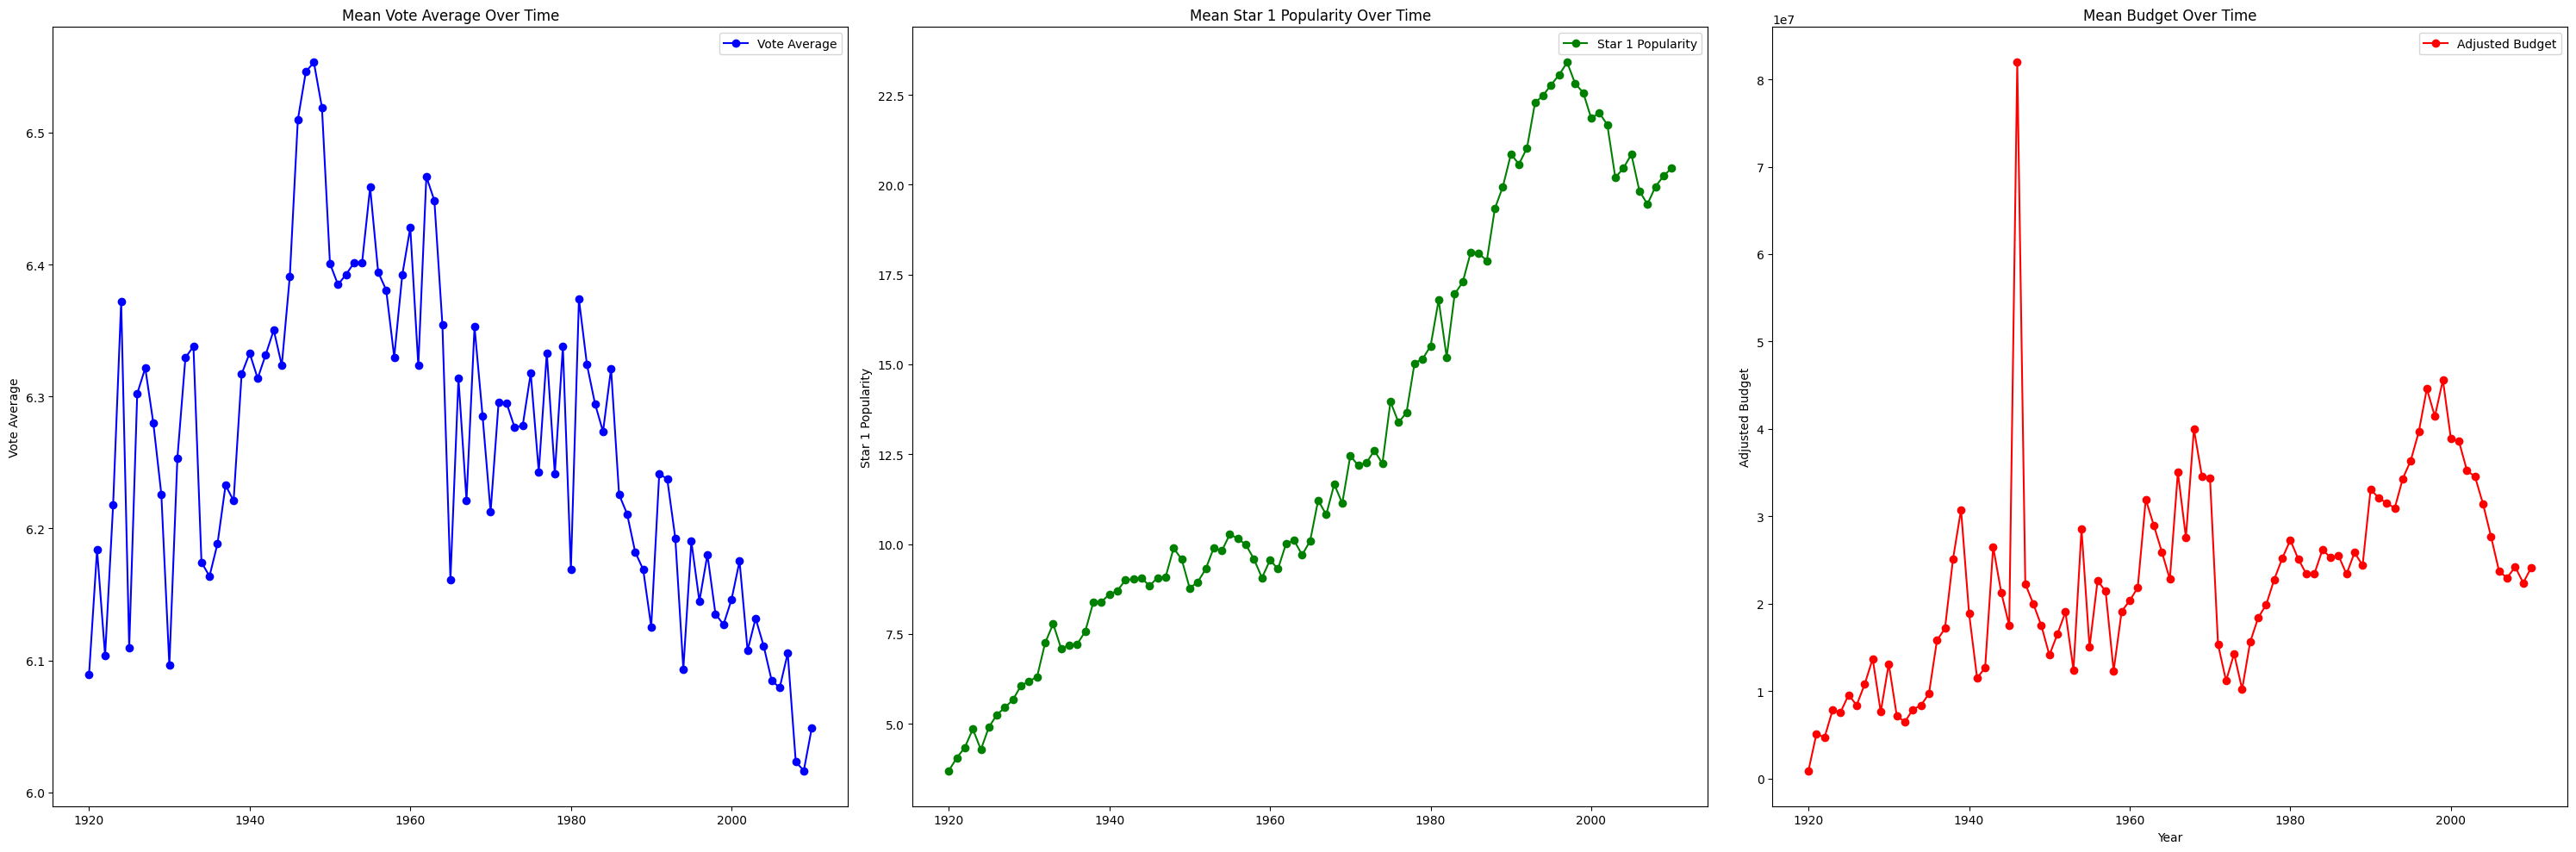

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

# Plot 1: Mean star_1_popularity over time
axes[0].plot(temp.index, temp['vote_average'], marker='o', label='Vote Average', color='blue')
axes[0].set_title('Mean Vote Average Over Time')
axes[0].set_ylabel('Vote Average')
axes[0].legend()

# Plot 2: Mean star_1_popularity over time
axes[1].plot(temp.index, temp['star_1_popularity'], marker='o', label='Star 1 Popularity', color='green')
axes[1].set_title('Mean Star 1 Popularity Over Time')
axes[1].set_ylabel('Star 1 Popularity')
axes[1].legend()

# Plot 3: Mean budget over time
axes[2].plot(temp.index, temp['adjusted_budget'], marker='o', label='Adjusted Budget', color='red')
axes[2].set_title('Mean Budget Over Time')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Adjusted Budget')
axes[2].legend()

plt.tight_layout()
plt.show()

### Assessing the Impact of Remakes: A Regression Analysis with Time Controls
To test whether the differences in star popularity, vote average, and budget between originals and remakes are statistically significant, we perform a regression analysis. Each feature (star popularity, vote average, and budget) is regressed on the following factors:

1. A dummy variable indicating whether a movie is an original (1 for original, 0 for remake).
2. Decade dummy variables to account for temporal trends over time.

By including the decade controls, we isolate the effect of being a remake or an original while accounting for broader trends across decades. The focus is on the coefficient of the original dummy variable to determine if it is statistically significant. This will help us identify whether the observed differences can be directly attributed to the nature of the movie (original vs. remake) or if they are better explained by time-based factors.

In [69]:
original_df_new , remakes_df_new = original_df.copy(deep = True), remakes_df.copy(deep = True)

original_df_new["original"] = 1.0
remakes_df_new["original"] = 0.0

originals_remakes = pd.concat([original_df_new, remakes_df_new])

originals_remakes['year_interval'] = pd.cut(originals_remakes['year'], bins=range(1900, 2031, 10), right=False, 
                             labels=[f"{i}-{i+9}" for i in range(1900, 2030, 10)])
originals_remakes['year_interval'] = originals_remakes['year_interval'].astype(str) 
year_dummies = pd.get_dummies(originals_remakes['year_interval'], drop_first=True)

In [70]:
# doing the regression for vote_average

data = originals_remakes[["original", "vote_average"]]
data = pd.concat([data, year_dummies], axis = 1)

data.dropna(inplace = True)

scaler = StandardScaler()

data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = data.drop(columns = ["vote_average"])
X = X.astype(float)
X = sm.add_constant(X)

y = data[["vote_average"]]
y = y.astype(float)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     31.52
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           9.41e-58
Time:                        22:53:37   Log-Likelihood:                -1317.6
No. Observations:                1035   AIC:                             2659.
Df Residuals:                    1023   BIC:                             2718.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.027e-15      0.027   -3.8e-14      1.0

In [71]:
# Here we plot the error bars for the coefficients of the regression

vote_coefs = plot_significance_plotly_regression_all(model, "DataStory/vote_average_errorbar.html")

In [72]:
# doing the regression for adjusted_budget

data = originals_remakes[["original", "adjusted_budget"]]
data = pd.concat([data, year_dummies], axis = 1)

data.dropna(inplace = True)

scaler = StandardScaler()

data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = data.drop(columns = ["adjusted_budget"])
X = X.astype(float)
X = sm.add_constant(X)

y = data[["adjusted_budget"]]
y = y.astype(float)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        adjusted_budget   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     10.24
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           9.06e-17
Time:                        22:53:38   Log-Likelihood:                -605.38
No. Observations:                 463   AIC:                             1235.
Df Residuals:                     451   BIC:                             1284.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.145e-16      0.042   2.72e-15      1.0

In [73]:
adjusted_budget_coefs = plot_significance_plotly(model, "DataStory/adjusted_budget_errorbar.html")

In [74]:
# doing the regression for star popularity

data = originals_remakes[["original", "star_1_popularity"]]
data = pd.concat([data, year_dummies], axis = 1)

data.dropna(inplace = True)

scaler = StandardScaler()

data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X = data.drop(columns = ["star_1_popularity"])
X = X.astype(float)
X = sm.add_constant(X)

y = data[["star_1_popularity"]]
y = y.astype(float)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      star_1_popularity   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     42.85
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           9.85e-77
Time:                        22:54:07   Log-Likelihood:                -1278.0
No. Observations:                1039   AIC:                             2580.
Df Residuals:                    1027   BIC:                             2639.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.821e-17      0.026   7.05e-16      1.0

In [67]:
star_popularity_coefs = plot_significance_plotly_regression_all(model, "DataStory/star_popularity.html")

## Pairwise Analysis of Originals and Their Remakes
Up until now, we compared the overall distributions of features (star popularity, vote average, and budget) for originals and remakes as separate groups. As a next step, we shift our focus to a more granular comparison by analyzing pairs of movies—each original and its corresponding remake. This pairwise analysis allows us to directly compare the features of remakes relative to their specific originals, providing deeper insights into how these features change when a movie is remade. By examining these pairs, we can better understand whether the observed trends hold consistently across individual original-remake pairs or are driven by broader patterns in the data.

### Testing for Differences: Mean and Median Analysis


In this analysis, we examine whether the mean and median of the differences between features of original movies and their remakes are significantly greater or less than zero. To test the mean, we use a one-sample t-test, and for the median, we apply the Wilcoxon signed-rank test.

In [11]:
movie_remakes_df_joined = pd.merge(movie_remakes_df, df_movies, left_on="remake_wikidata_id", right_on="wikidata_id", how="inner")

list_of_remakes_columns = movie_remakes_df_joined.columns[len(movie_remakes_df.columns):]
for column in list_of_remakes_columns:
    movie_remakes_df_joined.rename(columns={column: f'remake_{column}'}, inplace=True)


columns_number = len(movie_remakes_df_joined.columns)

movie_remakes_df_joined = pd.merge(movie_remakes_df_joined, df_movies, left_on="original_wikidata_id", right_on="wikidata_id", how="inner")
list_of_originals_columns = movie_remakes_df_joined.columns[columns_number:]
for column in list_of_originals_columns:
    movie_remakes_df_joined.rename(columns={column: f'original_{column}'}, inplace=True)


In [75]:
difference_data = {}

for column in numerical_columns:
    difference = movie_remakes_df_joined["original_" + column] - movie_remakes_df_joined["remake_" + column]
    difference.dropna(inplace = True)

    difference_data[column] = {"values": difference.to_list(),
                               "mean": difference.mean(),
                                "median": difference.median()}

    # Test mean using one-sample t-test (one-tailed)
    stat_mean, p_value_mean = ttest_1samp(difference, 0)

    # Adjust for one-tailed tests
    p_mean_greater = p_value_mean / 2 if stat_mean > 0 else 1.0
    p_mean_less = p_value_mean / 2 if stat_mean < 0 else 1.0

    if p_mean_greater < 0.05:
        print(f"{column}: Mean is significantly greater than zero (p = {p_mean_greater:.4f}).")
    elif p_mean_less < 0.05:
        print(f"{column}: Mean is significantly less than zero (p = {p_mean_less:.4f}).")
    else:
        print(f"{column}: Mean is not significantly different from zero.")

    # Test median using Wilcoxon signed-rank test (one-tailed)
    try:
        stat_median, p_value_median = wilcoxon(difference)

        # Adjust for one-tailed tests
        p_median_greater = p_value_median / 2 if np.median(difference) > 0 else 1.0
        p_median_less = p_value_median / 2 if np.median(difference) < 0 else 1.0

        if p_median_greater < 0.05:
            print(f"{column}: Median is significantly greater than zero (p = {p_median_greater:.4f}).")
        elif p_median_less < 0.05:
            print(f"{column}: Median is significantly less than zero (p = {p_median_less:.4f}).")
        else:
            print(f"{column}: Median is not significantly different from zero.")
    except ValueError:
        print(f"{column}: Wilcoxon test not applicable due to small sample size or zero differences.")


    mean_diff = difference.mean()
    median_diff = difference.median()

    fig = go.Figure()

    fig.add_trace(
        go.Histogram(
            x=difference,
            nbinsx=20,
            marker_color='blue',
            opacity=0.7,
            name='Difference'
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[mean_diff, mean_diff],
            y=[0, max(np.histogram(difference, bins=20)[0])],
            mode="lines",
            line=dict(color="red", width=2, dash="dash"),
            name=f"Mean ({mean_diff:.2f})",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[median_diff, median_diff],
            y=[0, max(np.histogram(difference, bins=20)[0])],
            mode="lines",
            line=dict(color="green", width=2, dash="dot"),
            name=f"Median ({median_diff:.2f})",
        )
    )

    fig.update_layout(
        title={
            'text': 'Difference Distribution',
            'x': 0.5,  
            'xanchor': 'center'
        },
        xaxis_title="Difference",
        yaxis_title="Frequency",
        barmode="overlay",
        template="plotly_white",
        legend=dict(x=0.9, y=0.9),
        autosize=True,  
        height=450,     
        width=700,       
    )

    pio.write_html(fig, f"DataStory/Differences/{column}_difference_distplot.html", auto_open=False, include_plotlyjs="cdn")
    # Show plot
    fig.show()


runtime: Mean is significantly less than zero (p = 0.0002).
runtime: Median is significantly less than zero (p = 0.0004).


star_1_popularity: Mean is significantly less than zero (p = 0.0000).
star_1_popularity: Median is significantly less than zero (p = 0.0000).


star_2_popularity: Mean is significantly less than zero (p = 0.0000).
star_2_popularity: Median is significantly less than zero (p = 0.0000).


star_3_popularity: Mean is significantly less than zero (p = 0.0000).
star_3_popularity: Median is significantly less than zero (p = 0.0000).


star_4_popularity: Mean is significantly less than zero (p = 0.0000).
star_4_popularity: Median is significantly less than zero (p = 0.0000).


star_5_popularity: Mean is significantly less than zero (p = 0.0000).
star_5_popularity: Median is significantly less than zero (p = 0.0000).


Director_popularity: Mean is not significantly different from zero.
Director_popularity: Median is not significantly different from zero.


Writer_popularity: Mean is not significantly different from zero.
Writer_popularity: Median is not significantly different from zero.


Producer_popularity: Mean is not significantly different from zero.
Producer_popularity: Median is not significantly different from zero.


vote_average: Mean is significantly greater than zero (p = 0.0000).
vote_average: Median is significantly greater than zero (p = 0.0000).


vote_count: Mean is significantly less than zero (p = 0.0110).
vote_count: Median is not significantly different from zero.


adjusted_revenue: Mean is significantly less than zero (p = 0.0184).
adjusted_revenue: Median is significantly less than zero (p = 0.0002).


adjusted_budget: Mean is significantly less than zero (p = 0.0000).
adjusted_budget: Median is significantly less than zero (p = 0.0000).


sentiment_score: Mean is not significantly different from zero.
sentiment_score: Median is not significantly different from zero.


### Analyzing Original Features that Influence Remake Features

To understand how original movie features influence remakes, we performed regression analyses on a selected subset of remake features: runtime, vote average, vote count, adjusted revenue, adjusted budget, and star 1 popularity. Using backward elimination, we identified the most relevant original features impacting each remake feature. The resulting coefficients reveal key relationships, offering insights into how original movies shape their remakes

In [76]:
# we only keep the columns which seem relevant to our analysis
regression_columns = [column for column in numerical_columns if "_popularity" not in column]
regression_columns.remove("sentiment_score")
regression_columns.append("star_1_popularity")

In [77]:
original_num_columns = ["original_" + column for column in regression_columns]
remake_num_columns = ["remake_" + column for column in regression_columns]


def backward_elimination(X, y, significance_level=0.05):
    num_vars = X.shape[1]
    for _ in range(num_vars):
        model = sm.OLS(y, X).fit()
        non_constant_pvalues = model.pvalues.drop(labels=['const'], errors='ignore')
        max_p_value = non_constant_pvalues.max()
        if max_p_value > significance_level:
            excluded_feature = non_constant_pvalues.idxmax()
            X = X.drop(columns=[excluded_feature])
        else:
            break
    return X, model

results_table = pd.DataFrame(index=remake_num_columns, columns=original_num_columns)

for remake_column in remake_num_columns:
    data = movie_remakes_df_joined.loc[:, original_num_columns + [remake_column]]
    data.dropna(inplace = True)
    print(f"number of remaining rows for {remake_column} = {len(data)}")
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    X, y = data_scaled[original_num_columns], data_scaled[[remake_column]]
    X = sm.add_constant(X)
    X, model = backward_elimination(X, y)

    for feature in original_num_columns:
        if feature in model.params.index:
            results_table.loc[remake_column, feature] = f"{model.params[feature]:.4f} (p={model.pvalues[feature]:.4f})"
        else:
            results_table.loc[remake_column, feature] = np.nan

    print(model.summary())
    print("###################################################################################")


# Save to a CSV file
results_table.to_csv("DataStory/regression_results.csv", index=True)


number of remaining rows for remake_runtime = 163
                            OLS Regression Results                            
Dep. Variable:         remake_runtime   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     39.05
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           3.55e-09
Time:                        22:59:57   Log-Likelihood:                -213.59
No. Observations:                 163   AIC:                             431.2
Df Residuals:                     161   BIC:                             437.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

# 2) Regression Analysis and Causal Inference

# 2.1) Feature Engineering

Before conducting regression analysis, we performed feature engineering on the dataset. First, we calculated the maximum popularity of the crew and the average popularity of the top three cast members, as they are the most influential individuals in a movie. We then identified the most common genres and created dummy variables for them. Additionally, we incorporated the sentiment score of the movie, its language, and the country of origin, specifically noting whether it was from the USA.

In [ ]:
df_movies = pd.read_csv(CONFIG["data_path"] / "MovieVerse.csv")

In [ ]:
df_movies.head()

In [ ]:
df_movies['budget'].isna().sum()

In [ ]:
df_movies.drop(columns=['Wikipedia_movie_ID', 'Freebase_movie_ID', 'movie_name', 'movie_summary', 'tmdb_id', 'imdb_id', 'titleType', 'budget', 'movie_revenue'], inplace=True)

In [ ]:
df_movies['adult'] = df_movies['adult'].astype(float)

In [ ]:
df_movies['crew_popularity_max'] = df_movies[['Director_popularity', 'Writer_popularity', 'Producer_popularity']].max(axis=1)
df_movies.drop(columns=['Director_popularity', 'Writer_popularity', 'Producer_popularity'], inplace=True)

In [ ]:
df_movies.describe()['crew_popularity_max']

In [ ]:
df_movies.drop(columns=['star_4_popularity', 'star_5_popularity'], inplace=True)
df_movies['cast_popularity_avg'] = df_movies[['star_1_popularity', 'star_2_popularity', 'star_3_popularity']].mean(axis=1)
df_movies.drop(columns=['star_1_popularity', 'star_2_popularity', 'star_3_popularity'], inplace=True)

In [ ]:
df_movies.describe()['cast_popularity_avg']

In [ ]:
most_genres = ["Drama", "Comedy", "Thriller", "Romance", "Action", "Black-And-White"]

def genres_dummies(row):
    if pd.isna(row):
        return [None] * len(most_genres)
    row = [r.strip() for r in row.split(', ')]
    dummies = []
    for g in most_genres:
        if g in row:
            dummies.append(1)
        else:
            dummies.append(0)
    return dummies

df_movies[[f'is_{genre}' for genre in most_genres]] = df_movies['movie_genres'].apply(genres_dummies).apply(pd.Series)
df_movies.drop(columns='movie_genres', inplace=True)

In [ ]:
df_movies.describe()[[f'is_{genre}' for genre in most_genres]]

In [ ]:
df_movies['sentiment_score'] = df_movies[['sentiment_label', 'sentiment_score']].dropna().apply(lambda x: x['sentiment_score'] if x['sentiment_label'] == 'POSITIVE' else 1 - x['sentiment_score'], axis=1)
df_movies.drop(columns='sentiment_label', inplace=True)

In [ ]:
df_movies.describe()['sentiment_score']

In [ ]:
df_movies['is_USA_movie'] = df_movies['movie_countries'].dropna().apply(lambda x: 'United States of America' in [country.strip() for country in  x.split(', ')])
df_movies['is_USA_movie'] = df_movies['is_USA_movie'].astype(float)
df_movies.drop(columns='movie_countries', inplace=True)

In [ ]:
df_movies.describe()['is_USA_movie']

In [ ]:
df_movies['is_en'] = df_movies['original_language'].dropna().apply(lambda x: x == 'en')
df_movies['is_en'] = df_movies['is_en'].astype(float)
df_movies.drop(columns='original_language', inplace=True)

In [ ]:
df_movies.describe()['is_en']

In [ ]:

df_movies['year_interval'] = pd.cut(df_movies['year'], bins=range(1880, 2031, 10), right=False,
                             labels=[f"{i}-{i+9}" for i in range(1880, 2030, 10)])
df_movies['year_interval'] = df_movies['year_interval'].astype(str)
df_movies['year_interval'] = df_movies[['year', 'year_interval']].apply(lambda x: '1888-1919' if x['year'] < 1920 else x['year_interval'], axis=1)
df_movies['year_interval'] = df_movies[['year', 'year_interval']].apply(lambda x: '2010-2021' if x['year'] >= 2010 else x['year_interval'], axis=1)
df_movies = pd.get_dummies(df_movies, columns=["year_interval"], drop_first=True)

df_movies.drop(columns=['year'], inplace=True)

In [ ]:
cols = []
for col in df_movies.columns:
    if col.startswith('year_interval'):
        cols.append(col)
df_movies.loc[df_movies['year_interval_nan'], cols] = None
df_movies.drop(columns=['year_interval_nan'], inplace=True)

In [ ]:
df_movies.describe()[[col for col in df_movies.columns if col.startswith('year_interval')]]


We analyse the correlation between the NaN values in the dataset. We observe that the NaN values are not correlated with each other. We then fill the NaN values using the datawig library. We fill each column using the other columns.

In [ ]:
nan_df = df_movies.isna()

nan_corr = nan_df.corr()

plt.figure(figsize=(8, 6))
plt.matshow(nan_corr, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(ticks=range(df_movies.shape[1]), labels=df_movies.columns, rotation=90)
plt.yticks(ticks=range(df_movies.shape[1]), labels=df_movies.columns)
plt.title("NaN Correlation Matrix", pad=20)
plt.show()

Missing values were imputed using the Datawig library, filling each column based on the others.

In [ ]:
cols = list(df_movies.columns)
cols.remove('wikidata_id')
imputed_dict = {}
for col in cols:
    print(col, ':')
    c_cols = cols.copy()
    c_cols.remove(col)
    imputer = SimpleImputer(
        input_columns=c_cols,
        output_column=col
    )
    imputer.fit(df_movies)
    imputed_dict[col] = imputer.predict(df_movies)[col]

for col in cols:
    df_movies.loc[df_movies[col].isna(), col] = imputed_dict[col][df_movies[col].isna()]

In [ ]:
df_movies.to_csv(CONFIG["data_path"] / "regression_data.csv", index=False)

# 2.2) Regression Analysis with All Features

In [34]:
df_movies = pd.read_csv(CONFIG["data_path"] / "regression_data.csv")
df_remakes_dataset = pd.read_csv(CONFIG["data_path"] / "remakes.csv")

We drop 'adult' since it has a lot of NANs.

In [35]:
df_movies['is_remake'] = df_movies["wikidata_id"].isin(df_remakes_dataset["remake_wikidata_id"])
df_movies['is_remake'] = df_movies['is_remake'].astype(float)
df_movies['has_remake'] = df_movies["wikidata_id"].isin(df_remakes_dataset["original_wikidata_id"])
df_movies['has_remake'] = df_movies['has_remake'].astype(float)
df_movies.drop(columns=['wikidata_id', 'adult'], inplace=True)

We also considered the release year of the movie and grouped it into intervals. Based on prior regression analysis, we observed that remakes or movies with remakes are more common before the 1980s, a period associated with the advent of color television.

In [36]:
df_movies['is_before_1980'] = 1 - df_movies['year_interval_1990-1999'] - df_movies['year_interval_2000-2009'] - df_movies['year_interval_2010-2021'] - df_movies['year_interval_1980-1989']
df_movies.drop(columns=[col for col in df_movies.columns if col.startswith('year_interval')], inplace=True)

Budget and revenue were also included, with a new feature created as the logarithm of the revenue-to-budget ratio. Revenue itself was excluded since we were primarily interested in its proportional relationship to the budget.

In [37]:
df_movies['log_revenue_budget_ratio'] = np.log(df_movies['adjusted_revenue']) - np.log(df_movies['adjusted_budget'])
df_movies.drop(columns=['adjusted_revenue'], inplace=True)

In [38]:
for col in df_movies.columns:
    df_movies[col] = df_movies[col].astype(float)

Dropping rows with missing values.

In [39]:

cols = list(df_movies.columns)
cat_cols = []
non_cat_cols = []
for col in cols:
    col = col.strip()
    if col.startswith('is') or col.startswith('year') or col in ['has_remake', 'adult']:
        cat_cols.append(col)
    else:
        non_cat_cols.append(col)

sc_ = StandardScaler()
df_movies.loc[:, non_cat_cols] = sc_.fit_transform(df_movies[non_cat_cols])
for col in non_cat_cols:
    df_movies.loc[df_movies[col].isna(), col] = 0
df_movies.dropna(inplace=True)


We perform regression analysis on the dataset, considering the presence of remakes and movies with remakes as the dependent variables. We then plot the significance of the coefficients and their confidence intervals. We then try to verify the causal effect of having a remake or being a remake on the feature that we see their significance.

We consider those as significant if their p-values are less than 0.05. The null hypothesis is that the coefficient is zero.

In [54]:
has_model = regress(df_movies, has_remake=True)
plot_significance_plotly_regression_all(has_model, 'has_remake.html', 'Coefficients and Confidence Intervals for Having Remake')

number of samples with positive y: 504.0
Optimization terminated successfully.
         Current function value: 0.035660
         Iterations 10
acc: 0.9927330581355349
f1: 0.01934235976789168
                           Logit Regression Results                           
Dep. Variable:             has_remake   No. Observations:                69768
Model:                          Logit   Df Residuals:                    69750
Method:                           MLE   Df Model:                           17
Date:                Fri, 20 Dec 2024   Pseudo R-squ.:                  0.1671
Time:                        22:08:10   Log-Likelihood:                -2487.9
converged:                       True   LL-Null:                       -2987.1
Covariance Type:            nonrobust   LLR p-value:                2.061e-201
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

,coef,lower,upper,significant
runtime,0.034749,0.008633,0.060865,True
vote_average,1.157773,1.027608,1.287938,True
vote_count,0.015430,-0.028421,0.059281,False
sentiment_score,-0.170518,-0.264404,-0.076632,True
adjusted_budget,-0.492948,-0.806586,-0.179310,True
crew_popularity_max,0.035049,-0.039901,0.109999,False
cast_popularity_avg,0.014784,-0.106036,0.135604,False
is_Drama,-0.068300,-0.266059,0.129459,False
is_Comedy,0.370652,0.158610,0.582694,True
is_Thriller,1.450672,1.220065,1.681279,True


In [55]:
res_model = regress(df_movies, has_remake=False)
plot_significance_plotly_regression_all(res_model, 'is_remake.html', 'Coefficients and Confidence Intervals for Being Remake')

number of samples with positive y: 498.0
Optimization terminated successfully.
         Current function value: 0.038279
         Iterations 10
acc: 0.9928327742897279
f1: 0.0
                           Logit Regression Results                           
Dep. Variable:              is_remake   No. Observations:                69762
Model:                          Logit   Df Residuals:                    69744
Method:                           MLE   Df Model:                           17
Date:                Fri, 20 Dec 2024   Pseudo R-squ.:                 0.09706
Time:                        22:08:12   Log-Likelihood:                -2670.4
converged:                       True   LL-Null:                       -2957.5
Covariance Type:            nonrobust   LLR p-value:                4.259e-111
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const 

,coef,lower,upper,significant
runtime,0.019672,-0.005671,0.045014,False
vote_average,0.042897,-0.061500,0.147293,False
vote_count,-0.047144,-0.105673,0.011386,False
sentiment_score,-0.180396,-0.273692,-0.087100,True
adjusted_budget,0.177222,0.075178,0.279265,True
crew_popularity_max,0.017115,-0.044542,0.078771,False
cast_popularity_avg,0.341796,0.271534,0.412059,True
is_Drama,-0.317863,-0.517252,-0.118474,True
is_Comedy,0.091115,-0.119675,0.301905,False
is_Thriller,0.887090,0.657391,1.116789,True


# 2.3) Causal Analysis

To assess the impact of being a remake or having a remake on the significance of specific features, we proceed as follows: for each column, we regress the feature of being a remake or having a remake. Next, we compute propensity scores and match samples accordingly. We then plot the average treatment effect (ATE) for the treated and control groups, including 95% confidence intervals. A feature is deemed to have a causal relationship with being a remake or having a remake if the ATE confidence interval excludes zero and the corresponding regression coefficient is statistically significant.
For recap,

$$ ATE = \frac{1}{N} \sum_i^N  y_{treat}^{(i)} - y_{\\control}^{(i)} $$

where $y_{treat}^{(i)}$ and $y_{\\control}^{(i)}$ are the outcomes for the treated and control samples, respectively. Here, treated samples are remakes or movies with remakes, and control samples are the rest. The outcome for the categorical variable is their value, and for the continuous variable, it is if the vlue is above the mean plus two times the standard deviation. This value is chosen to ensure to see if the feature has a significant effect on the outcome.

We assess the validity of the causal relationship using the bounded odds ratio (OR). Specifically, we constrain the matched pairs to have an upper bound of 5 for the odds ratio. To evaluate sensitivity, we plot a histogram of the odds ratios for the matched samples. The causal relationship is considered valid if the odds ratio is below 4, with the majority of matched samples exhibiting an odds ratio less than 2.


In [30]:
has_res = check_each_col_treat(df_movies, has_remake=True)
plot_ate_or_histograms(has_res, 'casual_has_remake.html', has_remake=True)

number of samples with positive y: 504

############## runtime ##############
Optimization terminated successfully.
         Current function value: 0.035678
         Iterations 10
thr: 1.4816240243549346 MAX_MATCHING_THRESHOLD: 0.0003206178922125016
runtime matched: 453
runtime matching ATE: -0.004415011037527594
runtime matching OR: 1.776247543679609

############## vote_average ##############
Optimization terminated successfully.
         Current function value: 0.038050
         Iterations 10
thr: 1.4617888764256195 MAX_MATCHING_THRESHOLD: 0.0003206178922125016
vote_average matched: 468
vote_average matching ATE: 0.057692307692307696
vote_average matching OR: 1.4400030169341553

############## vote_count ##############
Optimization terminated successfully.
         Current function value: 0.035663
         Iterations 10
thr: 1.4650997047343688 MAX_MATCHING_THRESHOLD: 0.0003206178922125016
vote_count matched: 456
vote_count matching ATE: 0.041666666666666664
vote_count matching OR: 

In [31]:
is_res = check_each_col_treat(df_movies, has_remake=False)
plot_ate_or_histograms(is_res, 'casual_is_remake.html', has_remake=False)

number of samples with positive y: 498

############## runtime ##############
Optimization terminated successfully.
         Current function value: 0.038289
         Iterations 10
thr: 1.4821069391069235 MAX_MATCHING_THRESHOLD: 0.0003187448555047871
runtime matched: 492
runtime matching ATE: -0.0040650406504065045
runtime matching OR: 1.220029396368024

############## vote_average ##############
Optimization terminated successfully.
         Current function value: 0.038283
         Iterations 10
thr: 1.454327292130337 MAX_MATCHING_THRESHOLD: 0.0003187448555047871
vote_average matched: 496
vote_average matching ATE: -0.006048387096774193
vote_average matching OR: 1.2716639315316405

############## vote_count ##############
Optimization terminated successfully.
         Current function value: 0.038300
         Iterations 10
thr: 1.4509955099689538 MAX_MATCHING_THRESHOLD: 0.0003187448555047871
vote_count matched: 494
vote_count matching ATE: -0.006072874493927126
vote_count matching OR

**Interpretation of the Results**

1. **Having a Remake**:
   When considering movies that have at least one subsequent remake, the following features showed a significant causal relationship:

   - **High Vote Average**:
     Movies that receive higher viewer ratings are more likely to inspire a remake. A possible interpretation is that higher-quality or more critically acclaimed films are deemed valuable intellectual property worth revisiting or updating for newer audiences.

   - **Being in Specific Genres (Comedy, Thriller, Romance)**:
     Certain genres appear more likely to inspire remakes.
     - *Comedy*: Comedies that resonate well with audiences may be remade to align with contemporary humor, cultural shifts, or to reach new demographic segments.
     - *Thriller*: Thrillers can be easily adapted to modern contexts and technologies, keeping their suspense elements fresh.
     - *Romance*: Romantic films that achieve a timeless emotional resonance may be reinterpreted for new eras or cultural backdrops.

   - **Black and White Movies**:
     Historically, many black-and-white classics have been remade in color or updated to reflect modern production values. This suggests that older, iconic films (often black and white) serve as prime candidates for remaking, potentially due to nostalgia, cinematic legacy, or the desire to revitalize stories for contemporary audiences.

   - **Made in the USA**:
     U.S.-produced films—given the global prominence of Hollywood—are more likely to be remade. This may stem from the wide international reach, market potential, and cultural influence of American cinema.

   - **Made Before 1980**:
     Older films, particularly from before 1980, are more frequently remade. As time passes, production values, storytelling techniques, and audience expectations shift, making these older stories appealing targets for modern reinterpretation.

   - **High Log of the Revenue-to-Budget Ratio**:
     Films that proved financially successful relative to their production costs are likely to catch the attention of filmmakers and studios looking for profitable properties to revisit. This financial indicator suggests that the perceived commercial viability drives the decision to invest in a remake.

2. **Being a Remake**:
   For movies that are themselves remakes of earlier works, the following features have a significant causal relationship:

   - **Negative Sentiment**:
     Remakes tend to arise even when the original film had lower sentiment or mixed reception. This might occur if the narrative concept is strong but the original execution was flawed, prompting a reimagined attempt to “fix” or improve upon the original’s shortcomings.

   - **High Budget**:
     Modern remakes are often given higher budgets, possibly to leverage updated technology, special effects, or star power. Studios may feel more confident investing heavily in known intellectual property, anticipating stronger box-office returns due to brand recognition.

   - **High Average Popularity of the First Three Cast Members**:
     Remakes often attach well-known or rising star actors to generate publicity and attract audiences. Casting high-profile talent can rekindle interest in a familiar story and differentiate the remake from its predecessor.

   - **Being in Specific Genres (Thriller, Romance)**:
     Similar to the pattern seen for having a remake, certain genres—thrillers and romances—are common subjects of remakes. These genres rely on timeless emotional or suspenseful narratives, making them ripe for re-interpretation and modernization.

   - **Made in the USA**:
     The U.S. film industry’s influence is again evident. Remakes are frequently developed within Hollywood, likely due to the robust infrastructure, global distribution networks, and a history of successful adaptations.

**Conclusion**:
The analysis suggests that certain film characteristics are causally linked to the likelihood of a movie having a remake or being a remake. Films that are older, successful, and produced in the U.S., and that belong to certain genres, appear more likely to inspire future remakes. For movies that are themselves remakes, factors like higher budgets, star-studded casts, and fitting into “remake-friendly” genres are associated with their production. Additionally, the sensitivity checks reinforce the credibility of these findings, indicating that these relationships are robust to concerns about potential unobserved confounders.